In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform


env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax
#jax.config.update("jax_enable_x64", True)
sys.path.append('../synax/')

import synax
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

2024-07-18 19:30:40.424414: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


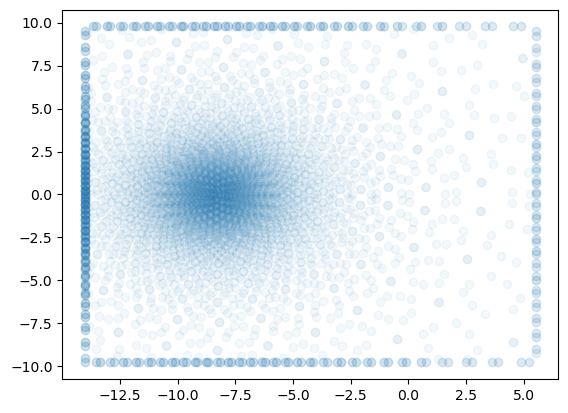

In [3]:
nside = 64
num_int_point = 1024
obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=num_int_point))
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs)
poss,dls,nhats = obtain_vmap(theta,phi)
nhats.shape
plt.scatter(poss[::10,0,500],poss[::10,1,500],alpha=0.05)

## Callable fields

In [4]:
@jax.jit
def C_page(x:float,y:float,z:float,C0:float = 1.,hr:float=5,hd:float=1):
    #x = x
    #z = z
    #c = (x**2+y**2+z**2)/jnp.max(jnp.array([x**2+y**2+z**2,9.]))+1e-7
    
    return C0*jnp.exp(-jnp.sqrt(x**2+y**2)/hr)/jnp.cosh(z/hd)**2#*(1-jnp.floor(c))


def C_uni(x:float,y:float,z:float,C0:float = 1.,):
    x = x+8.3
    z = z-0.006
    c = (x**2+y**2+z**2)/jnp.max(jnp.array([x**2+y**2+z**2,16]))+1e-7
    return 1-jnp.floor(c)

R_obs = (8.3**2+0.006**2)**0.5

def C_sun(x:float,y:float,z:float,C0:float = 6.4e1,):
    z = jnp.abs(z)
    factor1 = 1-jnp.floor(z/jnp.max(jnp.array([z,1])))
    R = (x**2+y**2)**0.5
    C = C0*jnp.exp(-(R-R_obs)/8-z)
    
    return factor1*C

def B_uni(x:float,y:float,z:float,Bx:float = 1.,By:float=0.,Bz:float=0.):
    x = x+8.3
    z = z-0.006
    c = (x**2+y**2+z**2)/jnp.max(jnp.array([x**2+y**2+z**2,16]))+1e-7
    return jnp.array([Bx,By,Bz])*(1-jnp.floor(c))*6e-6+1e-12

def TE_uni(x:float,y:float,z:float,ne:float = 0.01):
    x = x+8.3
    z = z-0.006
    c = (x**2+y**2+z**2)/jnp.max(jnp.array([x**2+y**2+z**2,16]))+1e-7
    return ne**(1-jnp.floor(c))

R_obs = (8.3**2+0.006**2)**0.5

C_earth = C_page(-8.3,0,0.006)
C_page_vmap = jax.vmap(lambda x,y,z:C_page(x,y,z))
C_uni_vmap = jax.vmap(lambda x,y,z:C_uni(x,y,z))
B_uni_vmap = jax.vmap(lambda x,y,z:B_uni(x,y,z))
TE_uni_vmap = jax.vmap(lambda x,y,z:TE_uni(x,y,z))
C_sun_vmap = jax.vmap(lambda x,y,z:C_sun(x,y,z))

'''def B_page(x:float,y:float,z:float,B0:float = 4.,chi0:float = 0.43633232,psi0:float = 0.47123888,psi1:float=0.01570796,hphi:float=8,hchi:float=1):
    r = jnp.sqrt(x**2+y**2)
    phi = jnp.atan2(x,y)
    psi_r = psi_0+psi_1*jnp.log()
    return '''

'def B_page(x:float,y:float,z:float,B0:float = 4.,chi0:float = 0.43633232,psi0:float = 0.47123888,psi1:float=0.01570796,hphi:float=8,hchi:float=1):\n    r = jnp.sqrt(x**2+y**2)\n    phi = jnp.atan2(x,y)\n    psi_r = psi_0+psi_1*jnp.log()\n    return '

In [5]:
nx,ny,nz = 256,256,64

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')

In [17]:
%%time
C_field = (C_uni_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))*4.013285414950239e1).reshape((nx,ny,nz))
B_field = (B_uni_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))).reshape((nx,ny,nz,3))
TE_field = (TE_uni_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))).reshape((nx,ny,nz))

CPU times: user 34.8 ms, sys: 41.9 ms, total: 76.7 ms
Wall time: 69.7 ms


In [7]:
interp_C_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,C_field,method='linear',extrap=True))
interp_B_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,B_field,method='linear',extrap=True))
interp_TE_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,TE_field,method='linear',extrap=True))

In [18]:
%%time
B_field_interp = interp_B_3d(poss)
C_field_interp = interp_C_3d(poss)
TE_field_interp = interp_TE_3d(poss)

CPU times: user 168 ms, sys: 58 ms, total: 226 ms
Wall time: 400 ms


In [9]:
B_los_square = ((nhats[:,jnp.newaxis,:]*B_field_interp)).sum(axis=-1)**2
#plt.imshow(B_los_square[:,:,32])


In [10]:
B_trans = ((B_field_interp**2).sum(axis=-1)-B_los_square)**0.5
#B_trans = C_field*1e-6*6

In [19]:
%%time
emiss = synax.sync_emiss_I(2.4,B_trans,C_field_interp,spectral_index=3.)
Sync_I = emiss.sum(axis=-1)*dls
Sync_I.shape

CPU times: user 1.19 ms, sys: 3.96 ms, total: 5.15 ms
Wall time: 3.07 ms


(49152,)

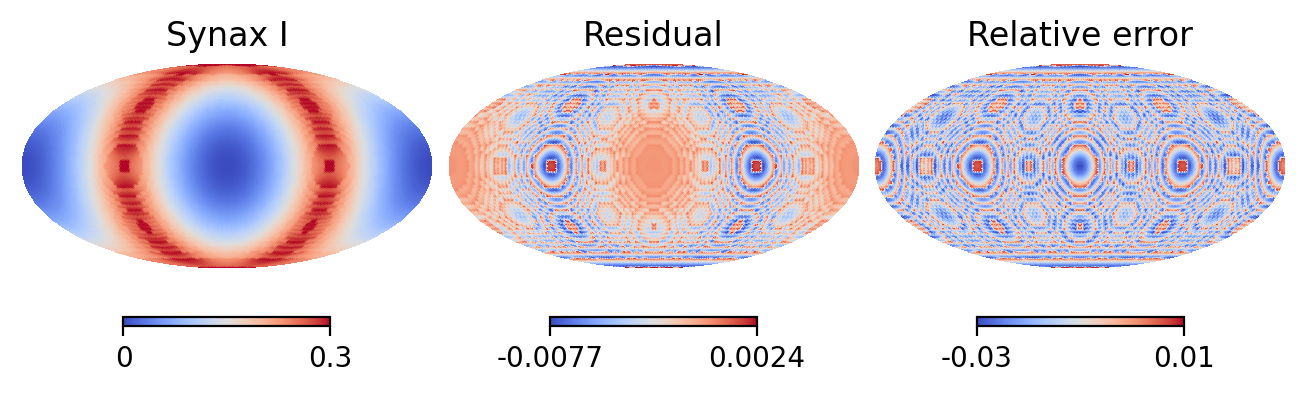

In [12]:
#emiss = emiss.at[100:110,10:20].set(1000)
ith = np.load('../../SyncEmiss/ith.npy')/1000
plt.figure(dpi=200)
hp.mollview(Sync_I,norm='hist',cmap='coolwarm',sub=(1,3,1),title = 'Synax I',max=0.3,min=0.0)
hp.mollview(Sync_I-ith,format='%.2g',cmap='coolwarm',sub=(1,3,2),title = 'Residual')
hp.mollview(2*(Sync_I-ith)/(Sync_I+ith),cmap='coolwarm',sub=(1,3,3),title = 'Relative error',max=0.01,min=-0.03)
plt.savefig('accuracy_I_grid.pdf',dpi=500,bbox_inches='tight')
#hp.mollview((Sync_I-ith)*2/(Sync_I+ith),norm='hist',cmap='coolwarm',sub=(1,3,3))#,max = 3*np.std((Sync_I-ith)/2/(Sync_I+ith)),min=-3*np.std((Sync_I-ith)/2/(Sync_I-ith)))

### Polarizations

In [13]:
q_converter = 1/(4*np.pi*const.epsilon_0)**0.5

B_converter = (4*np.pi/const.mu_0)**0.5

freq_irrelavent_const = (const.e*q_converter)**3/(const.electron_mass**2*const.speed_of_light**4)/(2*np.pi)*1e6*1e-4*B_converter*1e19*3.08 # moves 1/cm^3 = 1e6 1/m^3 1 gauss = 1e-4 tesla 1 kpc = 3.08e19 m here.

freq_irrelavent_const

810407283.1937842

In [14]:

def calc_pol(B_field,TE_field,C_field,freq):
    B_field = B_field
    B_los = -1*((nhats[:,jnp.newaxis,:]*B_field)).sum(axis=-1)
    phis = freq_irrelavent_const*TE_field*B_los
    
    sinb = nhats[...,2]
    cosb = jnp.sqrt(1-sinb**2)
    cosl = nhats[...,0]/cosb
    sinl = nhats[...,1]/cosb

    Bz = B_field[...,2]
    By = B_field[...,1]
    Bx = B_field[...,0]
    tanchi0 = (Bz*cosb[:,jnp.newaxis]-sinb[:,jnp.newaxis]*(cosl[:,jnp.newaxis]*Bx+By*sinl[:,jnp.newaxis]))/(Bx*sinl[:,jnp.newaxis]-By*cosl[:,jnp.newaxis])
    chi0 = jnp.arctan(tanchi0)
    phi_int = jnp.cumsum(phis,axis=1)*dls[:,jnp.newaxis]
    

    fd = phi_int*const.c**2/(freq**2*1e18)
    fd_q = jnp.cos(2*fd+2*chi0)
    fd_u = jnp.sin(2*fd+2*chi0)


    B_field_square = (B_field**2).sum(axis=-1)

    B_trans = (B_field_square-B_los**2)**0.5

    emiss = synax.sync_emiss_P(freq,B_trans,C_field,spectral_index=3.)
    #print()
    Sync_Q_int = (emiss*fd_q).sum(axis=-1)*dls
    Sync_U_int = (emiss*fd_u).sum(axis=-1)*dls
    
    return Sync_Q_int,Sync_U_int

In [16]:
%%time
Sync_Q,Sync_U = calc_pol(B_field_interp,TE_field_interp,C_field_interp,2.4)

CPU times: user 36.4 ms, sys: 80.6 ms, total: 117 ms
Wall time: 107 ms


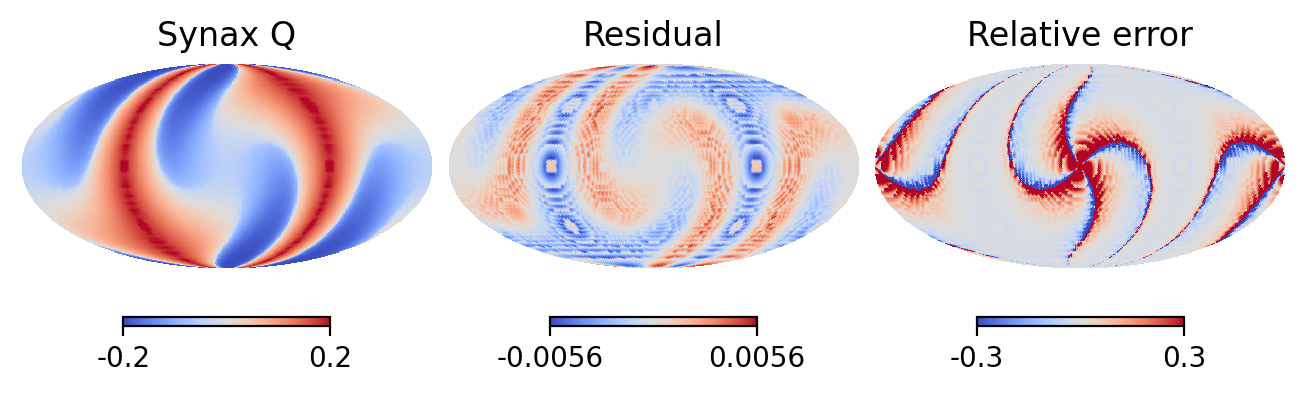

In [32]:
qth = np.load('../../SyncEmiss/qth.npy')/1000
plt.figure(dpi=200)
hp.mollview(Sync_Q,norm='hist',cmap='coolwarm',sub=(1,3,1),title = 'Synax Q',max=0.2,min=-0.2)
diff = np.array(Sync_Q-qth)
hp.mollview(Sync_Q-qth,format='%.2g',cmap='coolwarm',sub=(1,3,2),title = 'Residual')
hp.mollview(diff*2/(Sync_Q+qth),format='%.2g',cmap='coolwarm',sub=(1,3,3),title = 'Relative error',max=0.3,min=-0.3)
plt.savefig('accuracy_Q_grid.pdf',dpi=500,bbox_inches='tight')

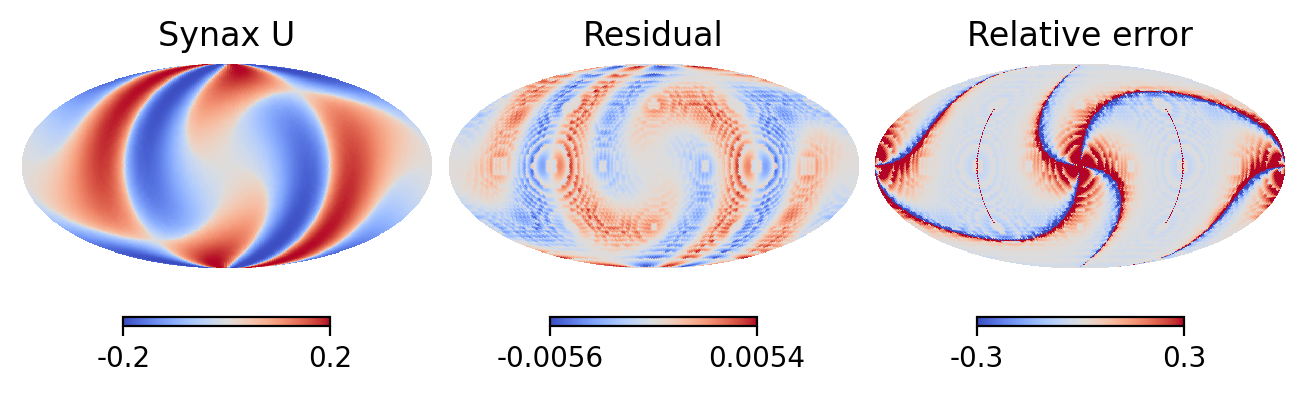

In [33]:
uth = np.load('../../SyncEmiss/uth.npy')/1000

plt.figure(dpi=200)
hp.mollview(Sync_U,norm='hist',cmap='coolwarm',sub=(1,3,1),title = 'Synax U',max=0.2,min=-0.2)
diff = np.array(Sync_U-uth)
hp.mollview(diff,format='%.2g',cmap='coolwarm',sub=(1,3,2),title = 'Residual')
hp.mollview(diff*2/(Sync_U+uth),format='%.2g',cmap='coolwarm',sub=(1,3,3),title = 'Relative error',max=0.3,min=-0.3)
plt.savefig('accuracy_U_grid.pdf',dpi=500,bbox_inches='tight')

(array([1.100e+01, 1.000e+01, 8.000e+00, 7.000e+00, 8.000e+00, 9.000e+00,
        1.700e+01, 6.000e+00, 4.000e+00, 1.100e+01, 1.100e+01, 7.000e+00,
        1.300e+01, 1.400e+01, 1.100e+01, 1.000e+01, 1.700e+01, 1.700e+01,
        1.600e+01, 1.100e+01, 1.500e+01, 2.400e+01, 2.400e+01, 2.500e+01,
        2.400e+01, 2.000e+01, 1.600e+01, 2.500e+01, 3.400e+01, 2.800e+01,
        2.900e+01, 4.100e+01, 3.700e+01, 3.400e+01, 6.200e+01, 5.800e+01,
        6.600e+01, 6.000e+01, 1.010e+02, 9.900e+01, 1.310e+02, 1.280e+02,
        1.580e+02, 2.630e+02, 3.340e+02, 4.750e+02, 7.220e+02, 1.292e+03,
        3.484e+03, 8.063e+03, 7.890e+03, 5.882e+03, 3.512e+03, 2.124e+03,
        1.653e+03, 1.423e+03, 1.205e+03, 9.640e+02, 7.880e+02, 6.930e+02,
        5.670e+02, 4.940e+02, 4.690e+02, 3.470e+02, 3.510e+02, 3.030e+02,
        2.530e+02, 2.440e+02, 2.390e+02, 2.070e+02, 1.870e+02, 1.870e+02,
        1.580e+02, 1.150e+02, 1.460e+02, 1.130e+02, 1.310e+02, 8.200e+01,
        1.080e+02, 1.100e+02, 6.000e+0

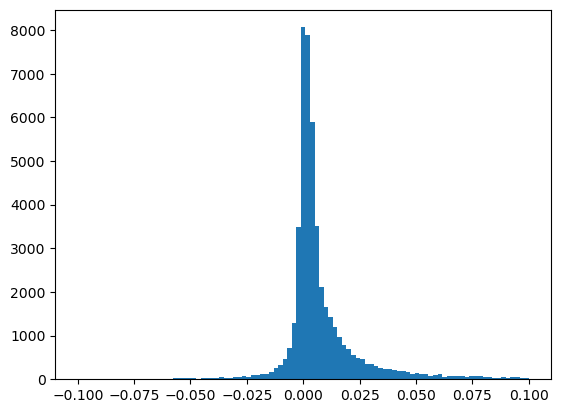